# c4

In [1]:
import sys
sys.path.append("/users/PAS0654/osu8354/root6_14_build/lib") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python2.7/site-packages")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib.pyplot as plt
#%jsroot on

Welcome to JupyROOT 6.14/06


## Calpulser 5 

### Import files and names

In [2]:
f1 = ROOT.TFile("/users/PCON0003/cond0068/ARA/AraRoot/analysis/calpul_box/A2_c4_DistroCalPulses_Pol0_CP5_forFit.root")
vpol_5=f1.Get("Colz_Vpol")
tree = f1.Get("OutputTree")


### Let's get the plots first


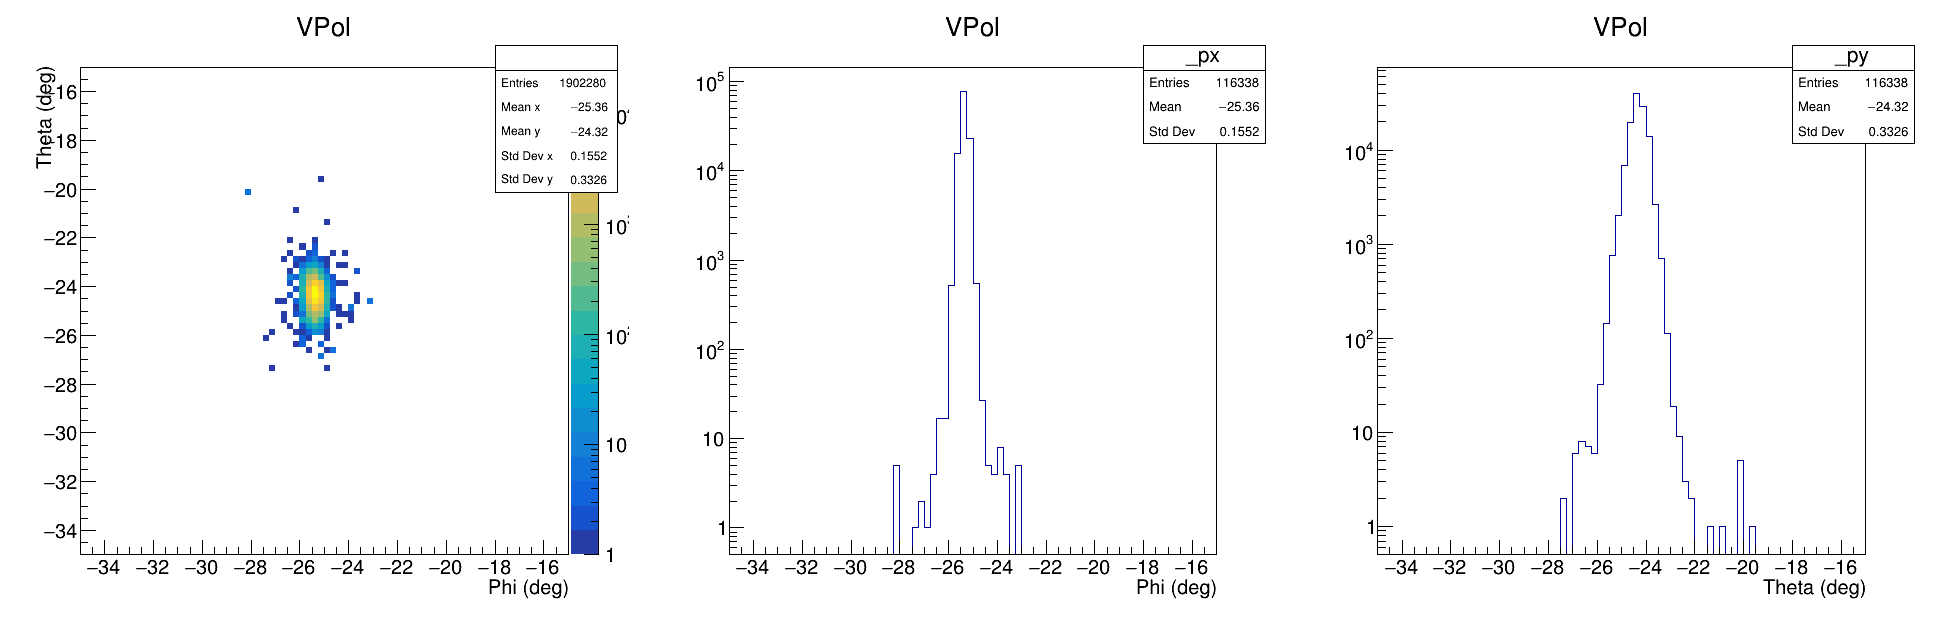

In [3]:
c=ROOT.TCanvas("","",650*3,650)
c.Divide(3,1)
c.cd(1)
vpol_5.Draw("COLZ")
gPad.SetLogz()
c.cd(2)
phi_proj_gaus_5=vpol_5.ProjectionX()
phi_proj_gaus_5.Draw()
gPad.SetLogy()
c.cd(3)
theta_proj_gaus_5=vpol_5.ProjectionY()
theta_proj_gaus_5.Draw()
gPad.SetLogy()
c.Draw()

In [4]:
phi_calpul_v=[]
th_calpul_v=[]
for entry in tree:
    if(entry.peakPhi_single_out<0 and entry.peakTheta_single_out<0 ):
        phi_calpul_v.append(entry.peakPhi_single_out)
        #phi_calpul_h.append(entry.peakPhi_single[1])
        th_calpul_v.append(entry.peakTheta_single_out)
        #th_calpul_h.append(entry.peakTheta_single[1])

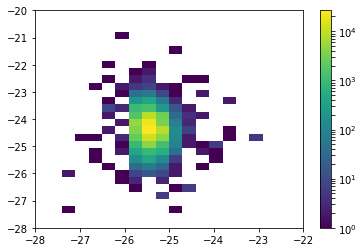

In [5]:
import matplotlib.colors as mcolors
plt.hist2d(phi_calpul_v, th_calpul_v,bins=(20,30),range=[[-28, -22], [-28, -20]], norm=mcolors.LogNorm());
plt.colorbar()
phi_calpul_v = np.array(phi_calpul_v)
th_calpul_v = np.array(th_calpul_v)

## Use KDE to fit

In [6]:
from sklearn.neighbors import KernelDensity

def kde2D(x, y, bandwidth, xbins=50j, ybins=50j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

In [7]:
xx, yy, zz = kde2D(phi_calpul_v, th_calpul_v, 1.0)

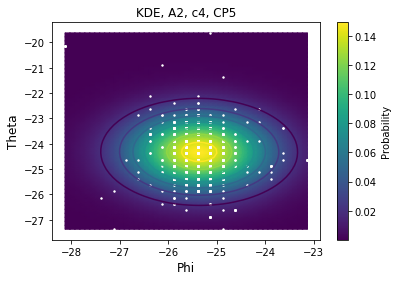

In [10]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
cmap = plt.get_cmap('PiYG')
cmap=plt.pcolormesh(xx, yy, zz,shading='gouraud')
plt.contour(xx, yy, zz)
plt.scatter(phi_calpul_v, th_calpul_v, s=2, facecolor="white" )
plt.colorbar(cmap,label='Probability')
# plt.ylim(0,10)
# plt.xlim(60,70)
#plt.axis('equal')
plt.xlabel("Phi", size=12)
plt.ylabel("Theta",size=12)
plt.title("KDE, A2, c4, CP5")
plt.savefig("/users/PCON0003/cond0068/ARA/KDE_A2_c4_CP5.png", dpi=200)

### Fitting attempt

In [43]:
phi_proj_5=vpol_5.ProjectionX()
theta_proj_5=vpol_5.ProjectionY()


j1 = ROOT.TF1("n1","gaus",-28,-20)
j2 = ROOT.TF1("n2","gaus",-26,-20)
#j3 = ROOT.TF1("n2","gaus",5,8)

#phi.Fit("gaus","S")
total_th = ROOT.TF1("nstotal","gaus(0)+gaus(3)",-28,-20)
total_th.SetLineColor(4)
theta_proj_5.Fit(j1,"0R");
theta_proj_5.Fit(j2,"0RQ+");
#theta_proj.Fit(j3,"0RQ+");
mean_th=np.zeros(6)
for i in range(0,3):
    mean_th[i]=j1.GetParameter(i)
for i in range(3,6):
    mean_th[i]=j2.GetParameter(i-3)
# for i in range(6,9):
#     mean_th[i]=j3.GetParameter(i-6)
total_th.SetParameters(mean_th);
allfit_theta=theta_proj_5.Fit(total_th,"ESRQ+")

g1 = ROOT.TF1("m1","gaus",-28,-24)
g2 = ROOT.TF1("m2","gaus",-24,-20)
g3 = ROOT.TF1("m2","pol2",-24,-18)

#The total is the sum of the three, each has 3 parameters
total = ROOT.TF1("mstotal","gaus(0)+gaus(3)+pol2(6)",-28,-18)
total.SetLineColor(4)
phi_proj_5.Fit(g1,"0R");
phi_proj_5.Fit(g2,"0RQ+");
phi_proj_5.Fit(g3,"0RQ+");

mean=np.zeros(9)
for i in range(0,3):
    mean[i]=g1.GetParameter(i)
for i in range(3,6):
    mean[i]=g2.GetParameter(i-3)
for i in range(6,9):
    mean[i]=g3.GetParameter(i-6)
total.SetParameters(mean);
allfit=phi_proj_5.Fit(total,"ERQS+")


 FCN=618.961 FROM MIGRAD    STATUS=CONVERGED      64 CALLS          65 TOTAL
                     EDM=8.08618e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.74462e+03   4.03811e+01   3.57547e-01   2.58524e-06
   2  Mean        -2.43659e+01   3.39165e-03   4.12342e-05   1.16310e-01
   3  Sigma        5.47154e-01   3.19097e-03   1.67614e-05   4.62879e-02
 FCN=248.798 FROM MIGRAD    STATUS=CONVERGED      65 CALLS          66 TOTAL
                     EDM=4.41385e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.03622e+04   8.34633e+01   4.92319e-01   2.79719e-06
   2  Mean        -2.52958e+01   1.56526e-03   1.20645e-05  -1.07878e-01
   3  Sigma        2.53919e-01   

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


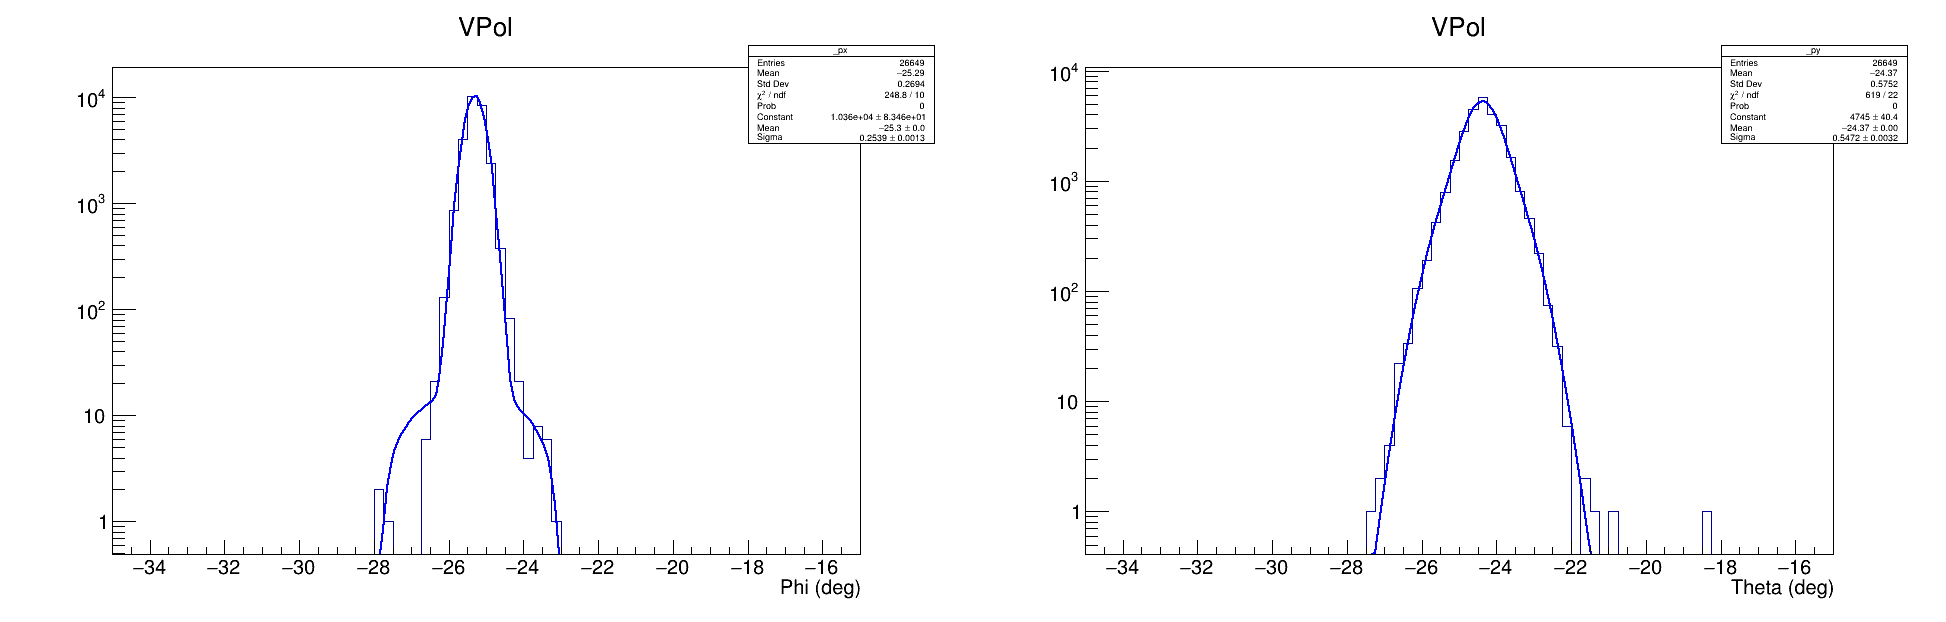

In [44]:
c=ROOT.TCanvas("","",650*3,650)
# phi_int=total.Integral(-27,-21)
# th_int=total_th.Integral(-30,-18)
# name_ph="Phi Projection Near peak, Integral="+ str(phi_int)
# name_th="Theta Projection Near peak, Integral="+ str(th_int)
c.Divide(2,1)

c.cd(1)
phi_proj_5.Draw()
gPad.SetLogy()
gStyle.SetOptFit(1111)

c.cd(2)
theta_proj_5.Draw()
gPad.SetLogy()
gStyle.SetOptFit(1111)
c.Draw()

## Calpulser 6

### Import files and names

In [13]:
f2 = ROOT.TFile("/users/PCON0003/cond0068/ARA/AraRoot/analysis/calpul_box/A2_c4_DistroCalPulses_Pol0_CP6_forFit.root")
vpol=f2.Get("Colz_Vpol")
tree_6 = f2.Get("OutputTree")

### Let's get the plots first

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


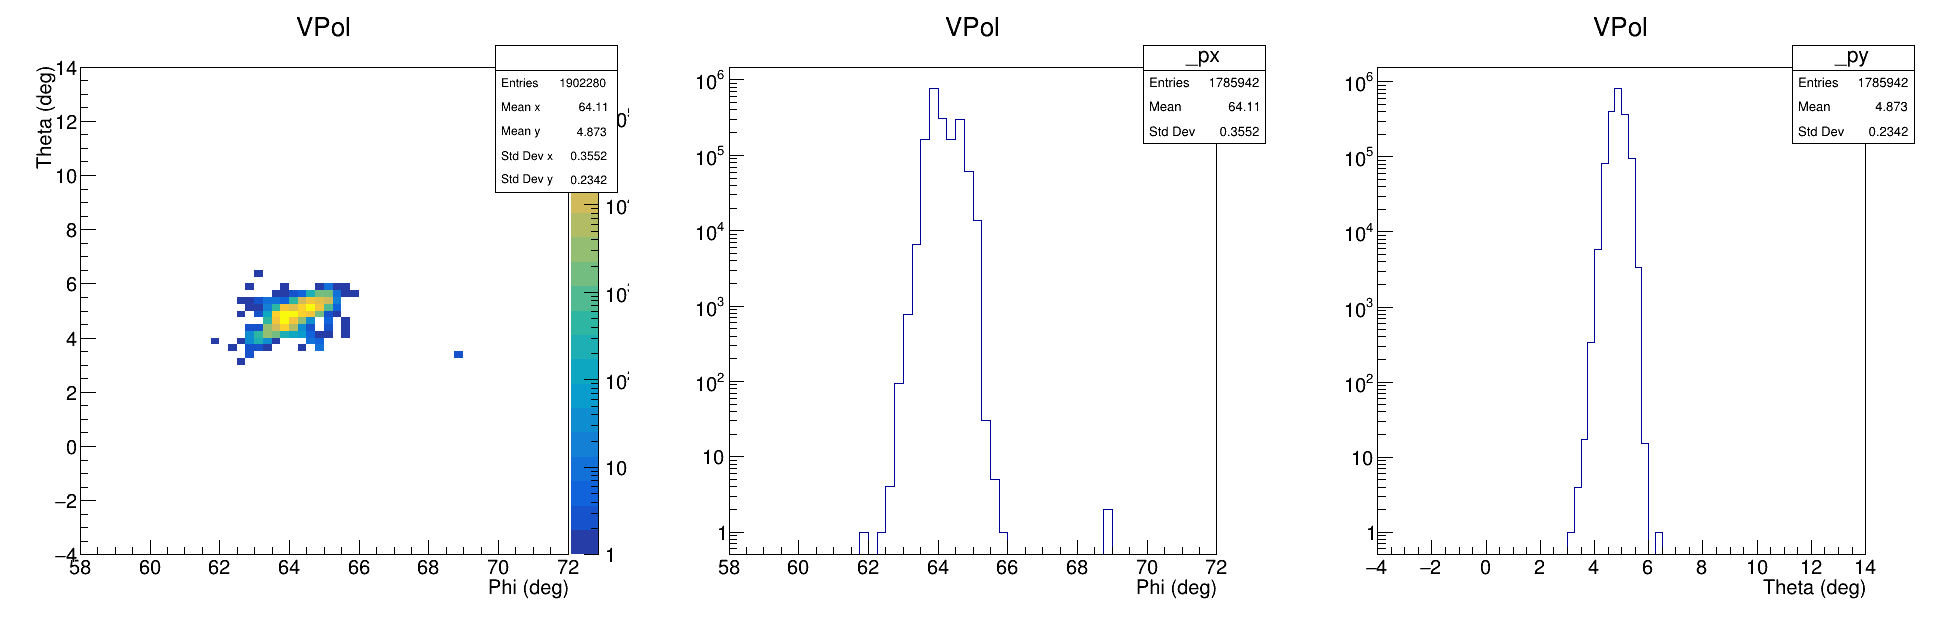

In [14]:
c=ROOT.TCanvas("","",650*3,650)
c.Divide(3,1)
c.cd(1)
vpol.Draw("COLZ")
gPad.SetLogz()
c.cd(2)
phi_proj_gaus=vpol.ProjectionX()
phi_proj_gaus.Draw()
gPad.SetLogy()
c.cd(3)
theta_proj_gaus=vpol.ProjectionY()
theta_proj_gaus.Draw()
gPad.SetLogy()
c.Draw()

In [15]:
phi_calpul_v_6=[]
th_calpul_v_6=[]
for entry in tree_6:
    if(entry.peakPhi_single_out>0 and entry.peakTheta_single_out>0 ):
        phi_calpul_v_6.append(entry.peakPhi_single_out)
        #phi_calpul_h.append(entry.peakPhi_single[1])
        th_calpul_v_6.append(entry.peakTheta_single_out)
        #th_calpul_h.append(entry.peakTheta_single[1])

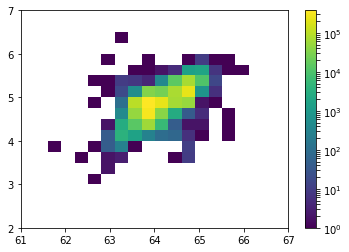

In [16]:
import matplotlib.colors as mcolors
plt.hist2d(phi_calpul_v_6, th_calpul_v_6,bins=(20,20),range=[[61, 67], [2, 7]], norm=mcolors.LogNorm());
plt.colorbar()
phi_calpul_v_6 = np.array(phi_calpul_v_6)
th_calpul_v_6 = np.array(th_calpul_v_6)

## Use KDE

In [17]:
xx, yy, zz = kde2D(phi_calpul_v_6, th_calpul_v_6, 1.0)

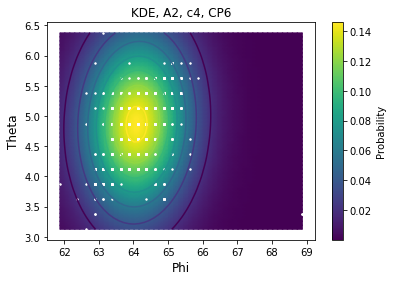

In [18]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
cmap = plt.get_cmap('PiYG')
cmap=plt.pcolormesh(xx, yy, zz,shading='gouraud')
plt.contour(xx, yy, zz)
plt.scatter(phi_calpul_v_6, th_calpul_v_6, s=2, facecolor="white" )
plt.colorbar(cmap,label='Probability')
# plt.ylim(0,10)
# plt.xlim(60,70)
#plt.axis('equal')
plt.xlabel("Phi", size=12)
plt.ylabel("Theta",size=12)
plt.title("KDE, A2, c4, CP6")
plt.savefig("/users/PCON0003/cond0068/ARA/KDE_A2_c4_CP6.png", dpi=200)

### Fit the distros

In [19]:
phi_proj=vpol.ProjectionX()
theta_proj=vpol.ProjectionY()


j1 = ROOT.TF1("n1","gaus",2,4)
j2 = ROOT.TF1("n2","gaus",4,6)
j3 = ROOT.TF1("n2","gaus",5,8)

#phi.Fit("gaus","S")
total_th = ROOT.TF1("nstotal","gaus(0)+gaus(3)+gaus(6)",0,9)
total_th.SetLineColor(4)
theta_proj.Fit(j1,"0R");
theta_proj.Fit(j2,"0RQ+");
theta_proj.Fit(j3,"0RQ+");
mean_th=np.zeros(9)
for i in range(0,3):
    mean_th[i]=j1.GetParameter(i)
for i in range(3,6):
    mean_th[i]=j2.GetParameter(i-3)
for i in range(6,9):
    mean_th[i]=j3.GetParameter(i-6)
total_th.SetParameters(mean_th);
allfit_theta=theta_proj.Fit(total_th,"ESRQ+")

g1 = ROOT.TF1("m1","gaus",62,64)
g2 = ROOT.TF1("m2","gaus",64,72)
g3 = ROOT.TF1("m2","gaus",62,68)

#The total is the sum of the three, each has 3 parameters
total = ROOT.TF1("mstotal","gaus(0)+gaus(3)+gaus(6)",60,76)
total.SetLineColor(4)
phi_proj.Fit(g1,"0R");
phi_proj.Fit(g2,"0RQ+");
phi_proj.Fit(g3,"0RQ+");

mean=np.zeros(9)
for i in range(0,3):
    mean[i]=g1.GetParameter(i)
for i in range(3,6):
    mean[i]=g2.GetParameter(i-3)
for i in range(6,9):
    mean[i]=g3.GetParameter(i-6)
total.SetParameters(mean);
allfit=phi_proj.Fit(total,"ERQS+")


 FCN=4.99978 FROM HESSE     STATUS=NOT POSDEF     16 CALLS          81 TOTAL
                     EDM=2.60124e-06    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.81922e+02   2.65077e+02   4.85479e-03   1.94318e-05
   2  Mean         3.83324e+00   9.25256e-02   1.44681e-06   1.05980e-01
   3  Sigma        8.34711e-02   4.61354e-02   3.05799e-06  -3.68294e-02
 FCN=760.356 FROM MIGRAD    STATUS=CONVERGED     168 CALLS         169 TOTAL
                     EDM=1.78645e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     9.37147e+05   5.18512e+03   1.27766e+01   7.84889e-08
   2  Mean         6.39941e+01   2.17967e-03   3.05148e-05  -4.51893e-01
   3  Sigma        1.97183e-01   

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


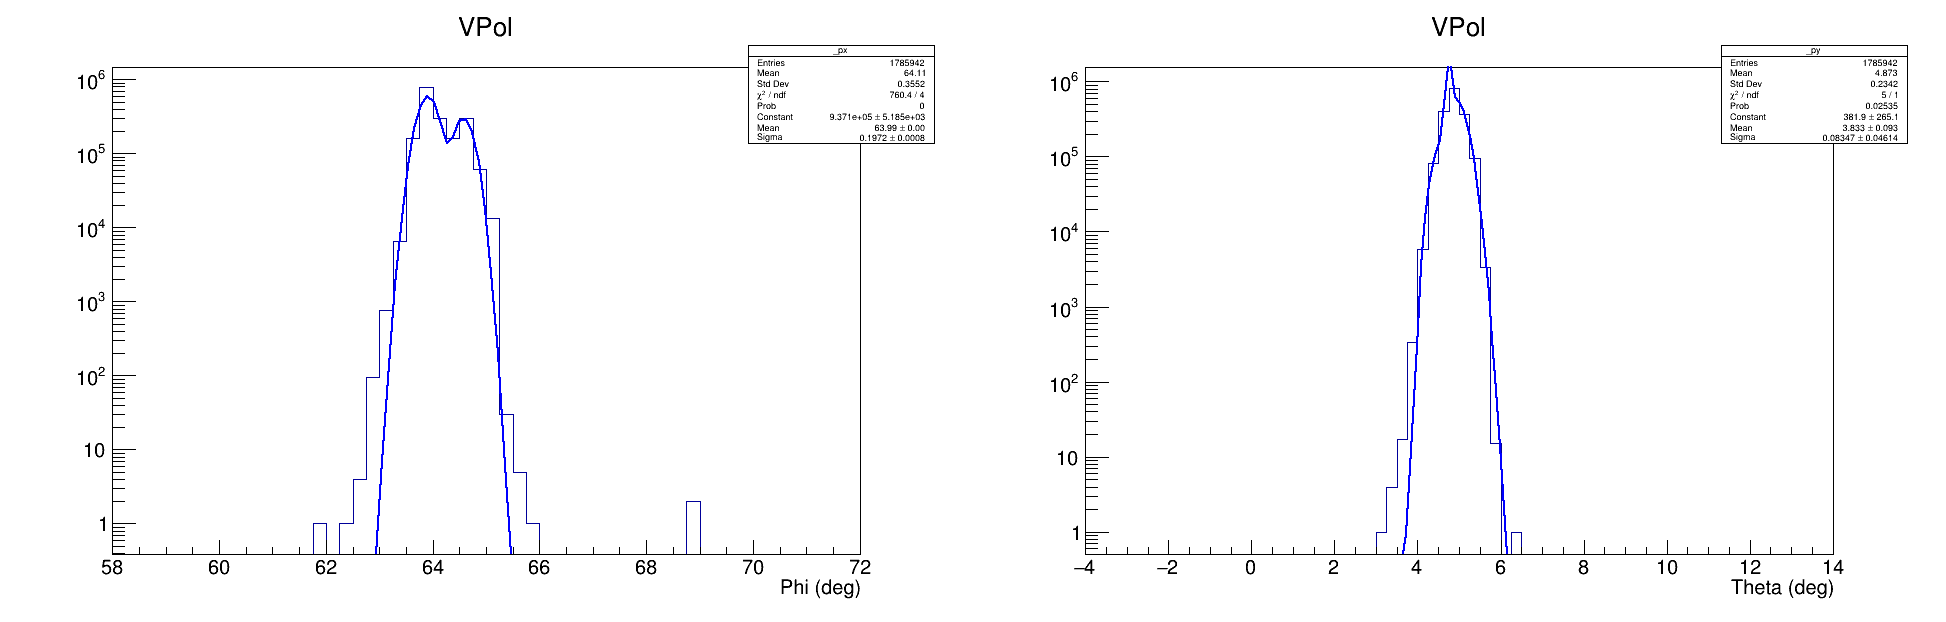

In [20]:
c=ROOT.TCanvas("","",650*3,650)
phi_int=total.Integral(-27,-21)
th_int=total_th.Integral(-30,-18)
name_ph="Phi Projection Near peak, Integral="+ str(phi_int)
name_th="Theta Projection Near peak, Integral="+ str(th_int)
c.Divide(2,1)

c.cd(1)
phi_proj.Draw()
gPad.SetLogy()
gStyle.SetOptFit(1111)

c.cd(2)
theta_proj.Draw()
gPad.SetLogy()
gStyle.SetOptFit(1111)
c.Draw()